# House Price Prediction

* From book "Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow"

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-poster')

In [3]:
df = pd.read_csv('./house.csv')
df.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1133,-121.62,39.75,20.0,1173.0,261.0,523.0,258.0,1.0625,92800.0,INLAND
16120,-122.46,37.78,52.0,2594.0,622.0,1421.0,593.0,3.0265,350000.0,NEAR BAY
9432,-122.81,38.08,19.0,1615.0,366.0,815.0,337.0,3.4609,238800.0,NEAR OCEAN
3984,-118.64,34.19,30.0,2399.0,373.0,1062.0,377.0,6.0094,245600.0,<1H OCEAN
3931,-118.59,34.21,26.0,2335.0,669.0,1986.0,645.0,2.9974,178800.0,<1H OCEAN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


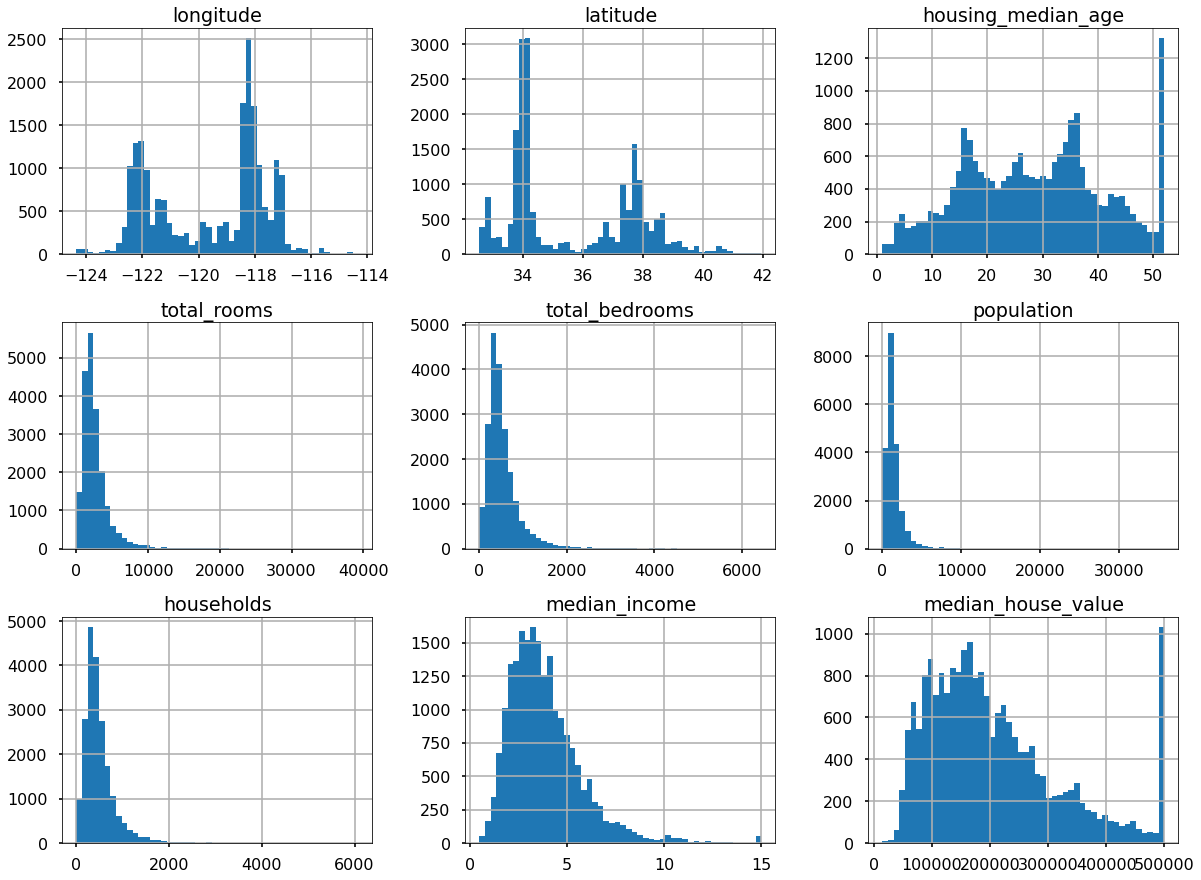

In [7]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train,test = split_train_test(df,0.2)

test.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8111,-118.20,33.79,48.0,2105.0,592.0,1807.0,539.0,2.7183,190400.0,NEAR OCEAN
5597,-118.23,33.80,26.0,239.0,135.0,165.0,112.0,1.3333,187500.0,NEAR OCEAN
1882,-119.99,38.94,24.0,1216.0,289.0,421.0,185.0,3.1625,103600.0,INLAND
12599,-121.49,38.53,42.0,1468.0,281.0,571.0,271.0,3.3906,124200.0,INLAND
8991,-118.35,34.00,30.0,1879.0,226.0,740.0,266.0,6.4310,492500.0,<1H OCEAN


### Solution to using same test set each time
- Using random seed
- Saving a test set and loading it each time   
But both these solutions will break the next time you fetch an updated dataset. To have a stable train/test split even after updating the dataset, a common solution is to
use each instance’s identifier to decide whether or not it should go in the test set
(assuming instances have a unique and immutable identifier). For example, you could
compute a hash of each instance’s identifier and put that instance in the test set if the
hash is lower than or equal to 20% of the maximum hash value. This ensures that the
test set will remain consistent across multiple runs, even if you refresh the dataset.
The new test set will contain 20% of the new instances, but it will not contain any
instance that was previously in the training set

In [10]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [11]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
df.reset_index()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


<AxesSubplot:>

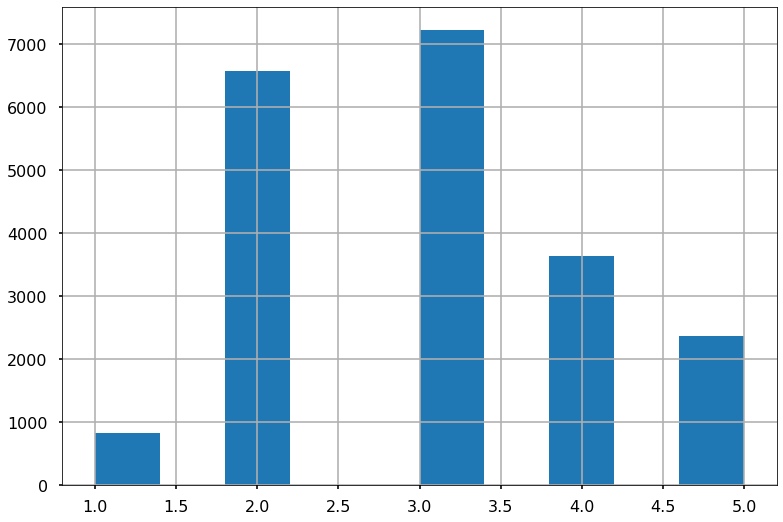

In [13]:
#linear data to categorical conversion
df["income_cat"] = pd.cut(df["median_income"],
                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["income_cat"]):
    print(train_index)
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

[17606 18632 14650 ... 13908 11159 15775]


In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

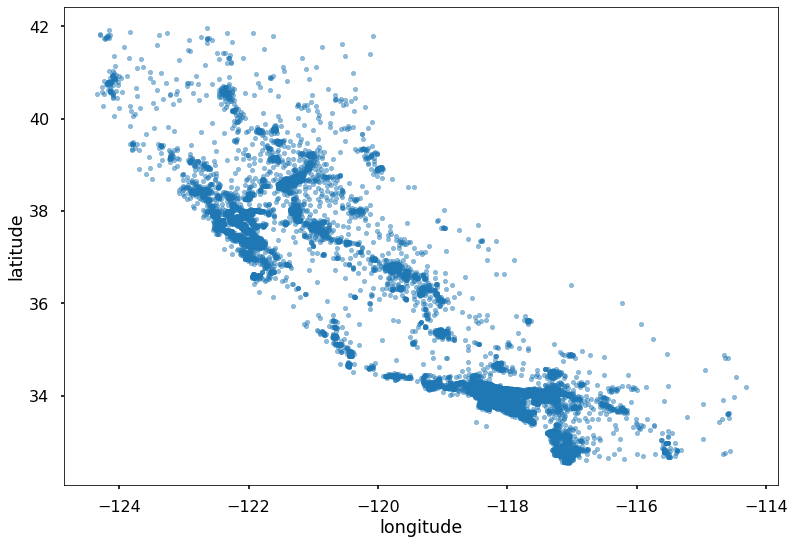

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5)

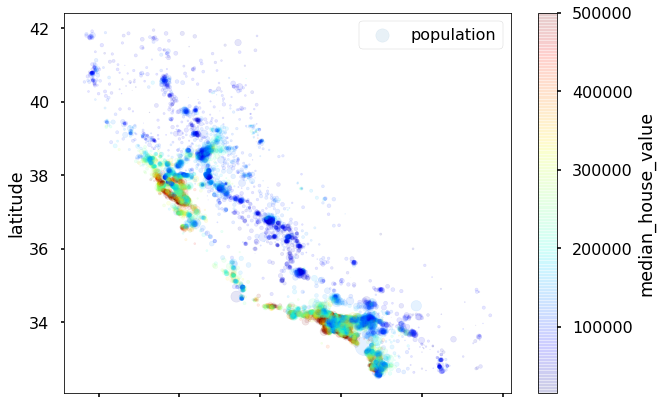

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [19]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


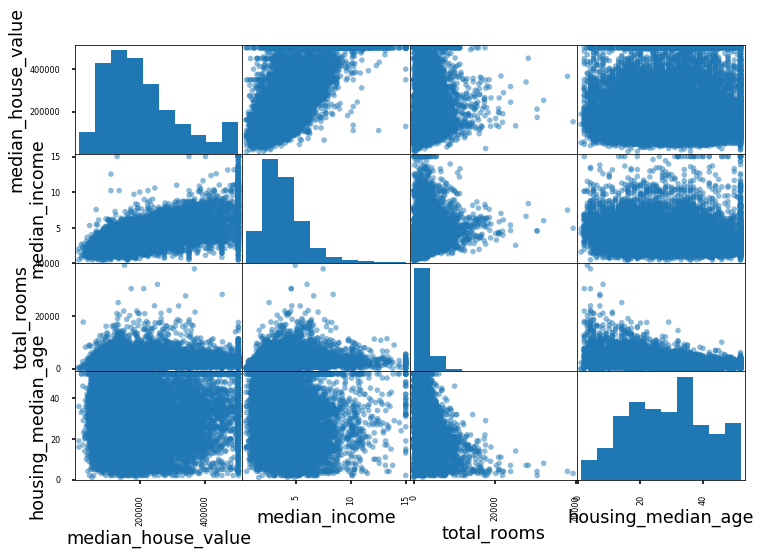

In [20]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

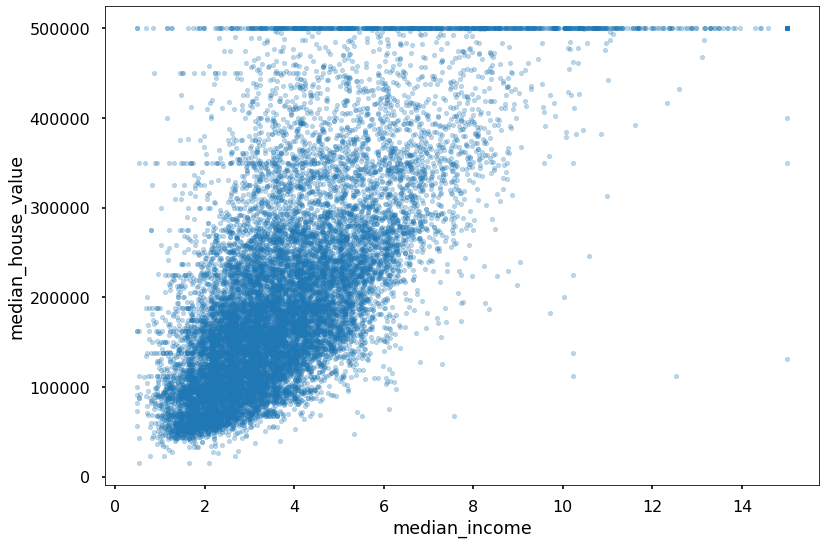

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.3)

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#median = housing["total_bedrooms"].median() 
#housing["total_bedrooms"].fillna(median, inplace=True)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
index=housing_num.index)

In [30]:
from sklearn.preprocessing import OneHotEncoder
housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat).toarray()
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Ref for pipeline
https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

In [35]:
#Custom transformer
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
        bedrooms_per_room]

In [37]:
#Pipelines for transformations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('attribs_adder', CombinedAttributesAdder()),
            ('std_scaler', StandardScaler()),
            ])
housing_num_tr = num_pipeline.fit_transform(housing_num)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", OneHotEncoder(), cat_attribs),
            ])
housing_prepared = full_pipeline.fit_transform(housing)

In [34]:
from sklearn.linear_model import LinearRegression

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [39]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [40]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [41]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [43]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# BoomBoom No error

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([68685.90803612, 67343.20500581, 70550.33225135, 68358.54609178,
       72300.91675061, 76093.13795777, 70649.41449624, 70424.31086231,
       76890.30777412, 70907.42430269])

In [46]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [68685.90803612 67343.20500581 70550.33225135 68358.54609178
 72300.91675061 76093.13795777 70649.41449624 70424.31086231
 76890.30777412 70907.42430269]
Mean: 71220.35035288244
Standard deviation: 2970.053384389808


In [47]:
#Cross validation for lin regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


### Oops! No error was due to overfitting of DecisionTreeRegressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_scores=mean_squared_error(housing_labels, forest_predictions)
forest_rmse_scores= np.sqrt(forest_scores)
display_scores(forest_rmse_scores)

Scores: 18728.44197840305
Mean: 18728.44197840305
Standard deviation: 0.0


In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [54]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [55]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)